This notebook demonstrates an end-to-end pipeline for topological feature extraction from medical images (PneumoniaMNIST) using Cubical Persistent Homology (PH).
We compute persistence diagrams, vectorize them via persistence images, and use Logistic Regression, XGBoost, Random Forest classifier for pneumonia diagnosis.
We also produce methods-figures for persistence diagrams and persistence images.

In [225]:
!pip install medmnist giotto-tda scikit-learn matplotlib seaborn gudhi

In [226]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import cv2
import skimage


import gudhi as gd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from medmnist import PneumoniaMNIST
from skimage import feature
import skimage.transform as tf

# Set random seed
#np.random.seed(42)

In [227]:
# Load PneumoniaMNIST dataset (2D grayscale chest X-ray images)

data = PneumoniaMNIST(split='train', download=True)
x_train, y_train = data.imgs, data.labels

data_test = PneumoniaMNIST(split='test', download=True)
x_test, y_test = data_test.imgs, data_test.labels

data_val = PneumoniaMNIST(split='val', download=True)
x_val, y_val = data_val.imgs, data_val.labels

print("Train:", x_train.shape, "Test:", x_test.shape, "Val:", x_val.shape)

Train: (4708, 28, 28) Test: (624, 28, 28) Val: (524, 28, 28)


In [228]:
# Flatten into shape (n_samples, height, width)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4708, 28, 28) (4708, 1)
(624, 28, 28) (624, 1)


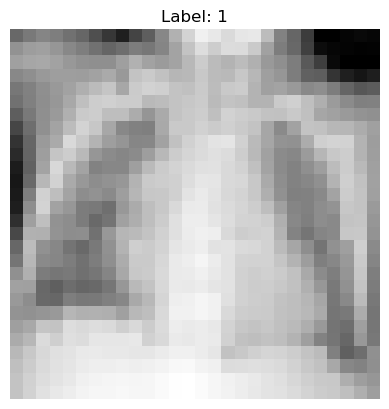

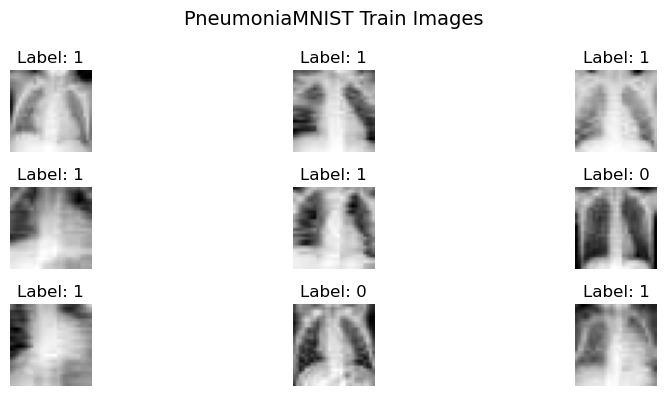

In [229]:
# Choose a single chest X-Ray image sample from the train set
sample = x_train[0]

#Plot the sample image

plt.imshow(sample, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

#Plot more samples from the train set

plt.figure(figsize=(10, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.suptitle("PneumoniaMNIST Train Images", fontsize=14)
plt.tight_layout()
plt.show()

In [230]:
# Store Cubical Persistence

cp = CubicalPersistence(homology_dimensions=[0, 1], coeff=3, n_jobs=-1)
cp0 = CubicalPersistence(homology_dimensions=[0], coeff=3, n_jobs=-1)
cp1 = CubicalPersistence(homology_dimensions=[1], coeff=3, n_jobs=-1)

In [283]:
# Persistent Diagrams

diagrams_train = cp.fit_transform(x_train)
diagram0_train = cp0.fit_transform(x_train)
diagram1_train = cp1.fit_transform(x_train)

diagrams_test = cp.fit_transform(x_test)

diagrams_val = cp.fit_transform(x_val)

diagram_sample = cp.fit_transform(sample[None, :, :])

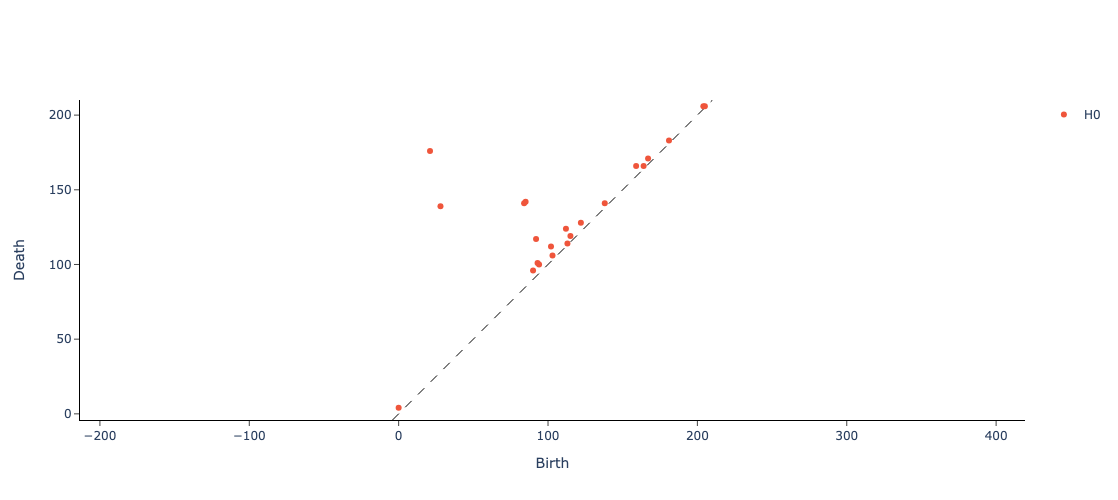

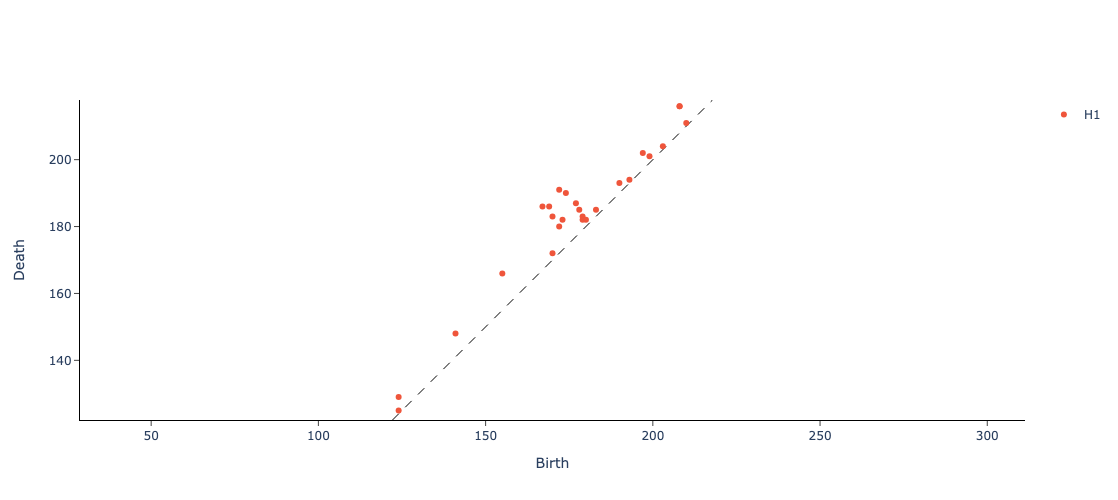

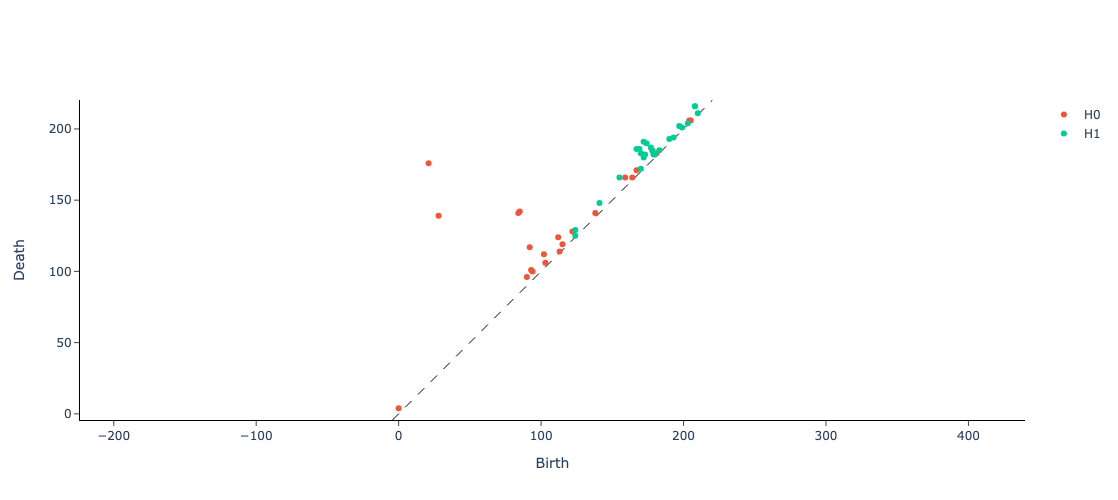

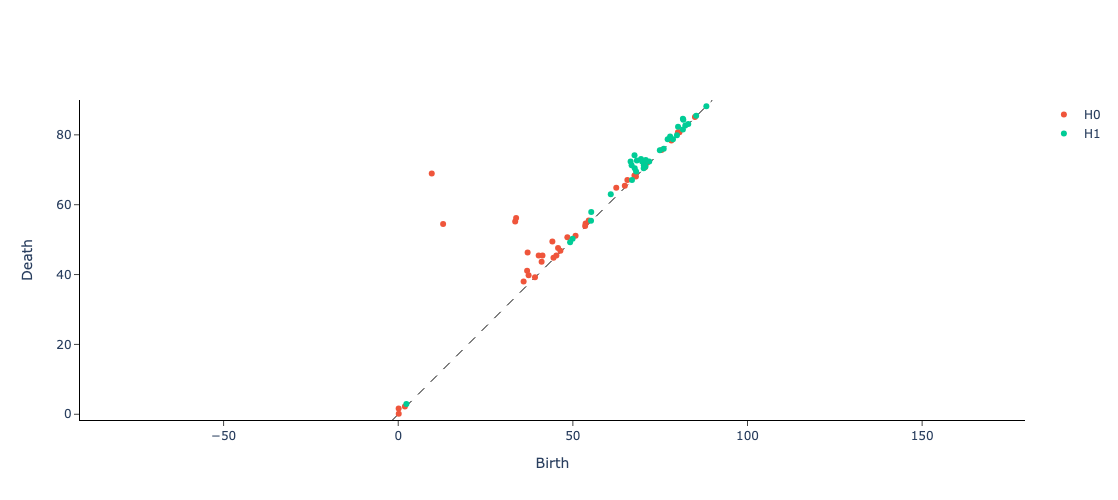

In [284]:
fig1 = plot_diagram(diagram0_train[0]) 
fig1.show()

fig2 = plot_diagram(diagram1_train[0])
fig2.show()

fig3 = plot_diagram(diagrams_train[0])
fig3.show()

fig4 = plot_diagram(diagram_sample[0])
fig4.show()

In [286]:
bc = BettiCurve(n_bins = 100)

betti0_curves = bc.fit_transform(diagram0_train)
betti1_curves = bc.fit_transform(diagram1_train)
print(betti0_curves.shape)  
print(betti1_curves.shape) 

betti_curves = bc.fit_transform(diagrams_train)
print(betti_curves.shape)

betti_curve_sample = bc.fit_transform(diagram_sample)
print(betti_curve_sample.shape)

betti_curve_test =bc.fit_transform(diagrams_test)
print(betti_curve_test.shape)

betti_curve_val = bc.fit_transform(diagrams_val)
print(betti_curve_val.shape)

(4708, 1, 100)
(4708, 1, 100)
(4708, 2, 100)
(1, 2, 100)
(624, 2, 100)
(524, 2, 100)


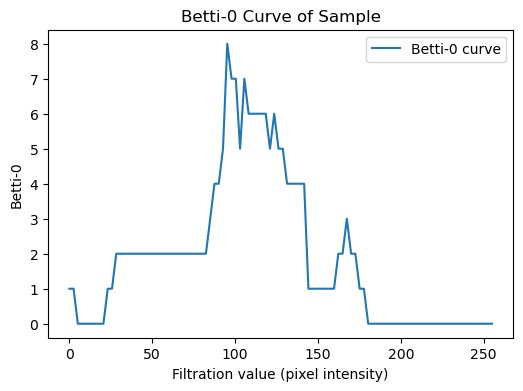

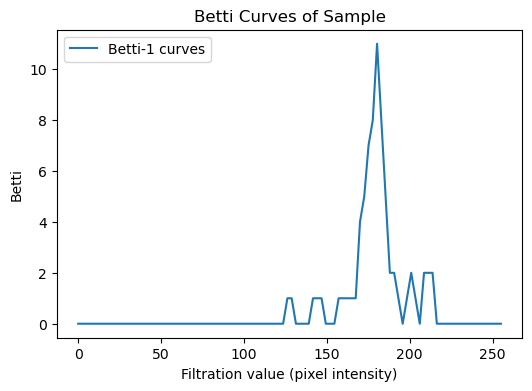

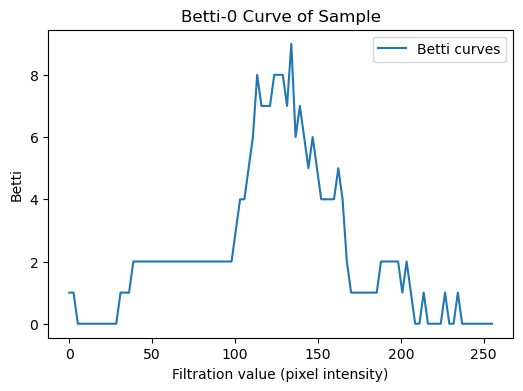

In [287]:
betti0 = betti0_curves[0, 0, :]   # first sample, H0 dimension
betti1 = betti_curves[0, 1, :]
betti0_sample = betti_curve_sample[0, 0, :]

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0)), betti0, label="Betti-0 curve")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti1)), betti1, label="Betti-1 curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti Curves of Sample")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0_sample)), betti0_sample, label="Betti curves")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

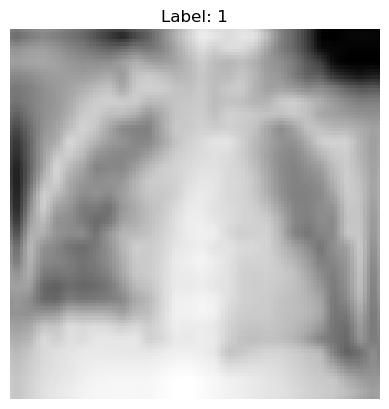

In [288]:

# Trying to preprocess the sample image hoping to extract more features (Betti and PI)

sample_up = tf.resize(sample, (112,112))


#Plot the upscaled sample image

plt.imshow(sample_up, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

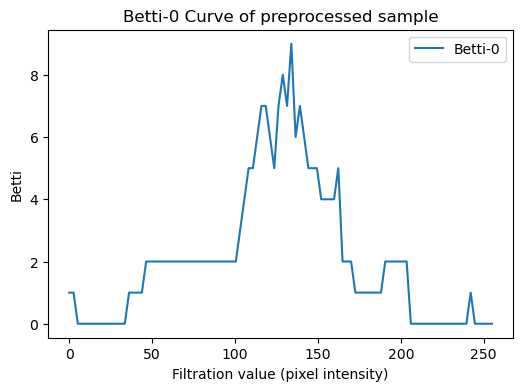

In [289]:
# Compute PD for preprocessed sample image
diagram_sample_up = cp.fit_transform(sample_up[None, :, :])

# Fit and transform PD to Betti curve
betti_curve_sample_up = bc.fit_transform(diagram_sample_up)

#Betti-0
betti0_sample_up = betti_curve_sample_up[0, 0, :]

# Plot Betti-0 curve for preprocessed sample
plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 255, len(betti0_sample_up)), betti0_sample_up, label="Betti-0")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti")
plt.title("Betti-0 Curve of preprocessed sample")
plt.legend()
plt.show()

PI feature shape: (4708, 2, 20, 20)
PI feature shape: (624, 2, 20, 20)
Flattened Train shape: (4708, 800)
Flattened Test shape: (624, 800)
Shape of one sample: (2, 20, 20)


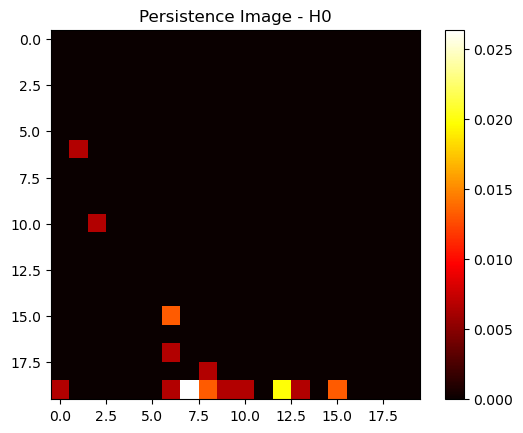

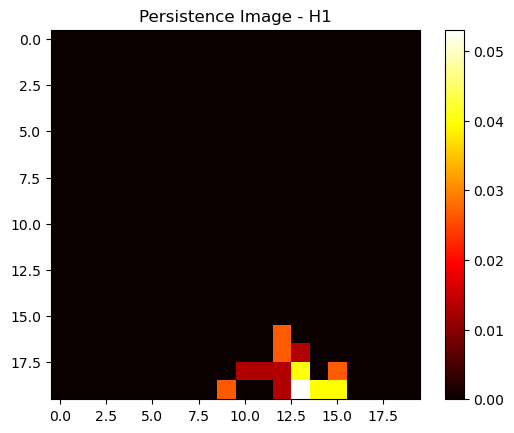

In [290]:
# Convert diagrams into persistence images

# Initialize Persistence Image Transformer
pi = PersistenceImage(n_bins=20, sigma=0.8, n_jobs=-1) # Change sigma later  

# Fit and transform PDs into PIs (returns vector for each image)
x_train_pi = pi.fit_transform(diagrams_train)
x_test_pi = pi.fit_transform(diagrams_test)

print("PI feature shape:", x_train_pi.shape) # (n_samples, hom_dim, n_bins, n_bins)
print("PI feature shape:", x_test_pi.shape)

# Flatten PI images for ML integration
x_train_flat = x_train_pi.reshape(len(x_train_pi), -1)
x_test_flat = x_test_pi.reshape(len(x_test_pi), -1)

print("Flattened Train shape:", x_train_flat.shape) # (n_samples, 2*20*20)
print("Flattened Test shape:", x_test_flat.shape)

# Visualize one sample (H0 and H1 PIs)

pi_sample = x_train_pi[0]

print("Shape of one sample:", x_train_pi[0].shape) 

# H0
plt.imshow(pi_sample[0], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H0")
plt.show()

# H1
plt.imshow(pi_sample[1], cmap="hot")
plt.colorbar()
plt.title("Persistence Image - H1")
plt.show()

In [293]:
print(betti_curves.shape)
print(y_train.shape)

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()
y_val_m = y_val.ravel()

print(x_train_m.shape)
print(y_train_m.shape)
print(y_test_m.shape)
print(y_val_m.shape)

(4708, 2, 100)
(4708, 1)
(3691072,)
(4708,)
(624,)
(524,)


In [294]:


betti0_curves = betti_curves[:, 0, :]  # H0
betti1_curves = betti_curves[:, 1, :]  # H1

betti0_normal = betti0_curves[y_train_m==0]
betti0_pneumonia = betti0_curves[y_train_m==1]
betti1_normal = betti1_curves[y_train_m==0]
betti1_pneumonia = betti1_curves[y_train_m==1]


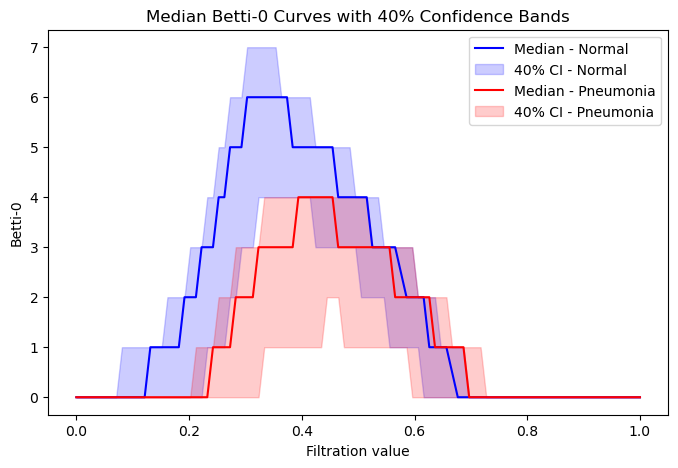

In [295]:
# Function to compute median and 40% confidence band
def median_and_band(curves, lower=20, upper=60):  # 40% band
    median = np.median(curves, axis=0)
    lb = np.percentile(curves, lower, axis=0)
    ub = np.percentile(curves, upper, axis=0)
    return median, lb, ub

# Compute median + 40% band for each class (H0 only)
median0_n, lb0_n, ub0_n = median_and_band(betti0_normal)
median0_p, lb0_p, ub0_p = median_and_band(betti0_pneumonia)

bins = np.linspace(0, 1, betti0_normal.shape[1])  # Filtration axis

plt.figure(figsize=(8,5))

# Plot Normal
plt.plot(bins, median0_n, color="blue", label="Median - Normal")
plt.fill_between(bins, lb0_n, ub0_n, color="blue", alpha=0.2, label="40% CI - Normal")

# Plot Pneumonia
plt.plot(bins, median0_p, color="red", label="Median - Pneumonia")
plt.fill_between(bins, lb0_p, ub0_p, color="red", alpha=0.2, label="40% CI - Pneumonia")

plt.xlabel("Filtration value")
plt.ylabel("Betti-0")
plt.title("Median Betti-0 Curves with 40% Confidence Bands")
plt.legend(loc="upper right")
plt.show()

In [296]:
print(np.min(x_train), np.max(x_train))

0 255


In [297]:
#x_train_scaled = x_train / np.max(x_train) * 100
x_train_scaled = (x_train - x_train.min()) / (x_train.max() - x_train.min()) * 100

In [298]:
from skimage.transform import resize
x_train_up = np.array([resize(img, (128,128)) for img in x_train_scaled])

In [299]:
print(y_train.shape)

(4708, 1)


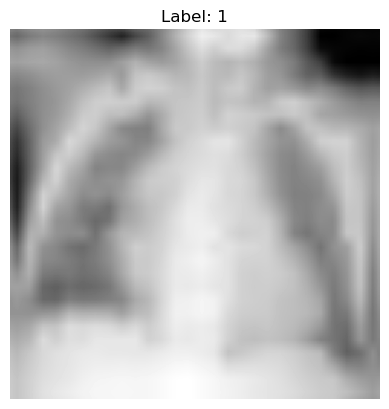

In [300]:
plt.imshow(x_train_up[0], cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()


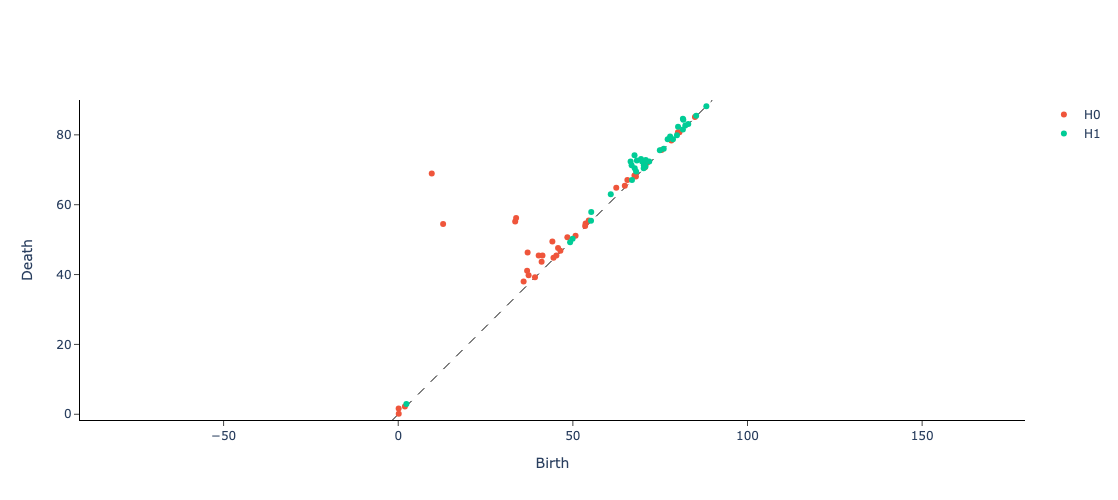

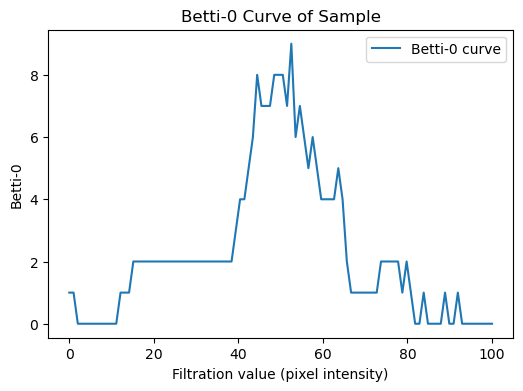

In [301]:
sample = x_train_up[0]
diagram_sample_up = cp.fit_transform(sample[None, :, :])
fig = plot_diagram(diagram_sample_up[0]) 
fig.show()
betti_sample_up = bc.fit_transform(diagram_sample_up)
betti0_up = betti_sample_up[0, 0, :]

plt.figure(figsize=(6,4))
plt.plot(np.linspace(0, 100, len(betti0_up)), betti0_up, label="Betti-0 curve")
plt.xlabel("Filtration value (pixel intensity)")
plt.ylabel("Betti-0")
plt.title("Betti-0 Curve of Sample")
plt.legend()
plt.show()

In [302]:
y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()
y_val_m = y_val.ravel()

X_train_vec = betti_curves.reshape(betti_curves.shape[0], -1)
X_test_vec = betti_curve_test.reshape(betti_curve_test.shape[0], -1)
print("Flattened train shape:", X_train_vec.shape)
print("Flattened test shape:", X_test_vec.shape)
print("Flattened train label shape:", y_train_m.shape)
print("Flattened test label shape:", y_test_m.shape)

print("y_train:", y_train_m.shape)
print("y_test:", y_test_m.shape)
print("y_val:", y_val_m.shape)

Flattened train shape: (4708, 200)
Flattened test shape: (624, 200)
Flattened train label shape: (4708,)
Flattened test label shape: (624,)
y_train: (4708,)
y_test: (624,)
y_val: (524,)


Accuracy: 0.7676282051282052
              precision    recall  f1-score   support

           0       0.83      0.47      0.60       234
           1       0.75      0.94      0.84       390

    accuracy                           0.77       624
   macro avg       0.79      0.71      0.72       624
weighted avg       0.78      0.77      0.75       624

ROC AUC: 0.8917543282927899


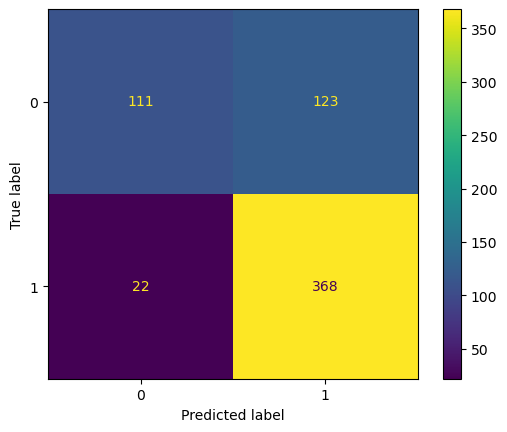

In [307]:
# Random Forest model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_vec, y_train_m)

y_pred = clf.predict(X_test_vec)
y_proba = clf.predict_proba(X_test_vec)[:, 1]

print("Accuracy:", accuracy_score(y_test_m, y_pred))
print(classification_report(y_test_m, y_pred))
print("ROC AUC:", roc_auc_score(y_test_m, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred)
plt.show()

Accuracy: 0.7516025641025641
              precision    recall  f1-score   support

           0       0.81      0.44      0.57       234
           1       0.74      0.94      0.83       390

    accuracy                           0.75       624
   macro avg       0.77      0.69      0.70       624
weighted avg       0.76      0.75      0.73       624

ROC AUC: 0.830418584264738


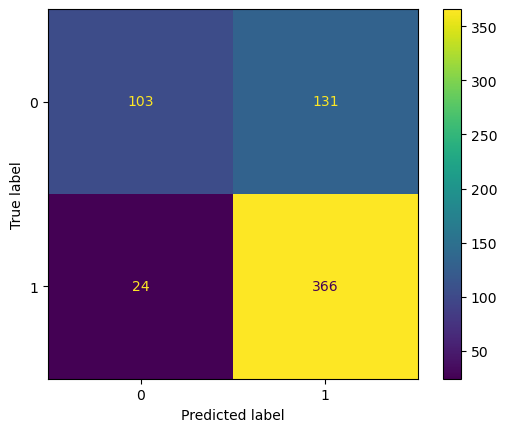

In [308]:
# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Fit model
lr_model.fit(X_train_vec, y_train_m)

# Predict
y_pred = lr_model.predict(X_test_vec)
y_proba =lr_model.predict_proba(X_test_vec)[:, 1]
# Evaluate
print("Accuracy:", accuracy_score(y_test_m, y_pred))
print(classification_report(y_test_m, y_pred))
print("ROC AUC:", roc_auc_score(y_test_m, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred)
plt.show()